Part 2: Data Preview and Pipeline


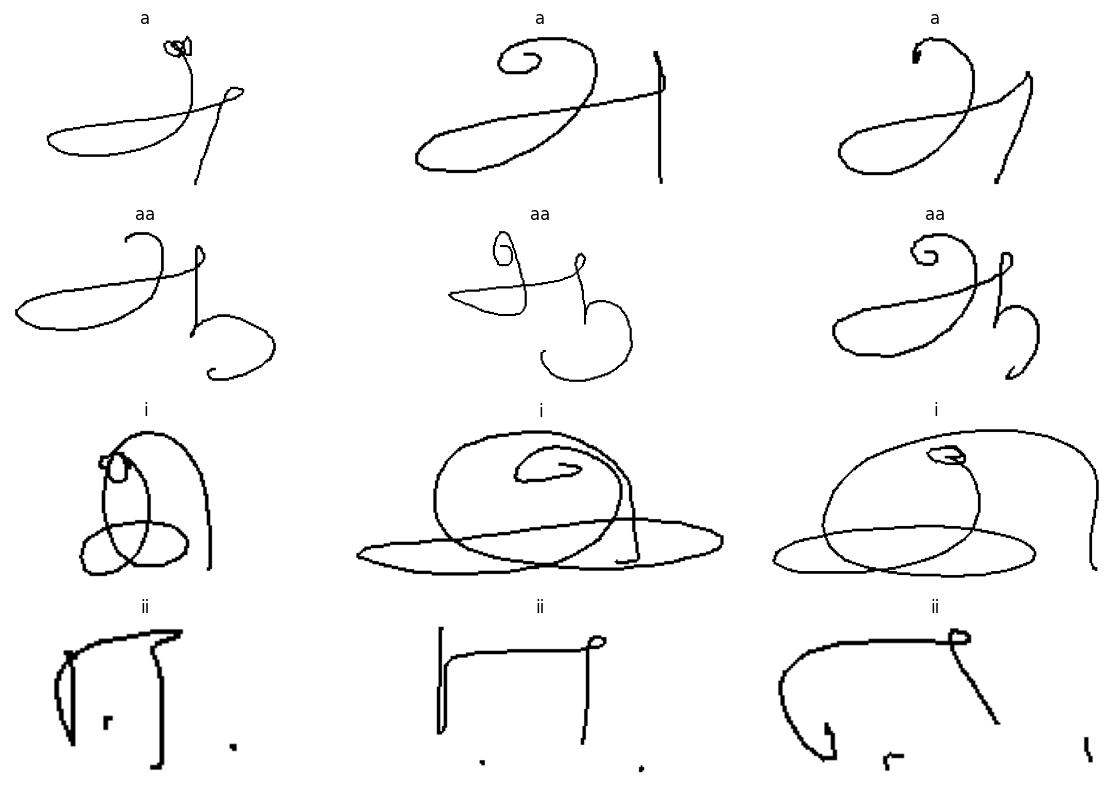

In [1]:
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Dataset path
train_dir = "final_data/train"
classes = os.listdir(train_dir)

plt.figure(figsize=(12, 8))
img_count = 1

for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    images = random.sample(os.listdir(class_path), 3)
    
    for img_name in images:
        img_path = os.path.join(class_path, img_name)
        # Load image using tf.keras.utils.load_img
        img = tf.keras.utils.load_img(img_path, color_mode="grayscale")
        # Convert to array
        img_array = tf.keras.utils.img_to_array(img)
        
        plt.subplot(len(classes), 3, img_count)
        plt.imshow(tf.squeeze(img_array), cmap="gray")
        plt.title(class_name)
        plt.axis("off")
        img_count += 1

plt.tight_layout()
plt.show()


Part 3: Model Definition, Tuning, and Training

Model Definition: Define two models: a custom Simple CNN and a Transfer Learning Model
(MobileNetV2)

Simple CNN 

In [ ]:
import tensorflow as tf

def build_simple_cnn(input_shape=(64,64,1), num_classes=4):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),  # <-- input layer
        
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Instantiate
simple_cnn = build_simple_cnn()
simple_cnn.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,140 (2.61 MB)

 Trainable params: 683,140 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

Transfer Learning Model (MobileNetV2)

In [11]:
import tensorflow as tf

# Input
input_tensor = tf.keras.Input(shape=(224, 224, 1))  # Resize input to 224x224

# Convert grayscale to RGB
x = tf.keras.layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x))(input_tensor)

# Load MobileNetV2 with proper input shape
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model.trainable = False

# Forward pass
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
output = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=input_tensor, outputs=output)
model.summary()


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)